
## Problem statement:

Given a directed social graph,we have to predict missing links to recommend friends/connections/followers(Link prediction in graph).


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Overview:
Data has taken from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting
Data contains two columns:
* Source_node: int 64
* destination_node: int 64

There are about 9.43M directed edges and 1.86M vertices/users.
#### Note:

Data is dynamic i.e given data is one snapshot at timestamp t.


## Mapping the problem into supervised learning problem:
This problem is a binary classification problem with 0 implying an absence of an edge and 1 employing the presence as y-i's.for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link.
*  Reference papers and videos :

 * https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
 * https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
 * https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
 * https://www.youtube.com/watch?v=2M77Hgy17cg


## Business objectives and constraints:
* No low-latency requirements.
* Predicting the link probability is important for recommending the highest probability links to a user.
* Suggested links should be most likely to be correct and try to not miss out any connections.


## Performance metric for supervised learning:
* Both precision and recall is important so F1 score is good choice
*Confusion metrix

### 1.Importing necessary libraries

In [0]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
import networkx as nx
import pdb




In [0]:
# Reading the graph
if not os.path.isfile('train_woheader.csv'):
  traincsv=pd.read_csv('/content/drive/My Drive/train.csv')
  print(traincsv[traincsv.isna().any(1)])
  print(traincsv.info())
  print("Number of duplicate entries: ",sum(traincsv.duplicated()))
  traincsv.to_csv('train_woheader.csv',header=False,index=False)
  print("saved the graph into file")
else:
    g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))
  

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


### Visualize subgraph

Name: 
Type: DiGraph
Number of nodes: 34
Number of edges: 25
Average in degree:   0.7353
Average out degree:   0.7353


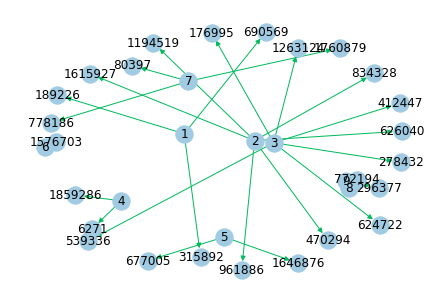

In [0]:
if not os.path.isfile('train_woheader_sample.csv'):
  pd.read_csv('/content/drive/My Drive/train.csv',nrows=25).to_csv('train_woheader_sample.csv',header=False,index=False)
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Reds,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))
  
        
  

### 2. Exploratory Data Analysis

In [0]:
print("Number of unique persons:",len(g.nodes))

Number of unique persons: 1862220


### 2.1 Number of followers for each person

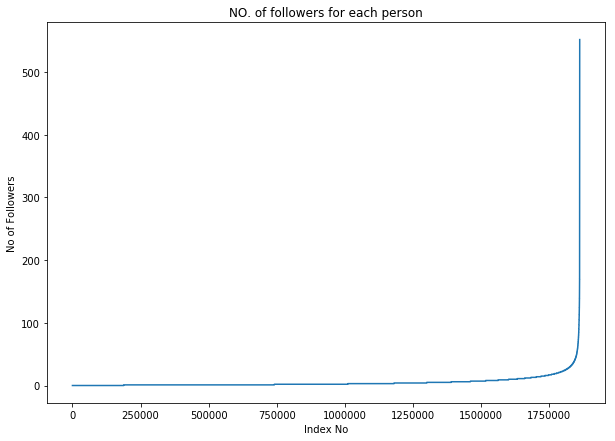

In [0]:
indegree_dist=list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,7))
plt.plot(indegree_dist)
plt.title("NO. of followers for each person")
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

#### Observations:
* In given datasets most of users have less than '40' followers.
* Only few users has more than '40' followers.
* There is atleast one user has more than '500' followers.

#### Zoomed into above fig

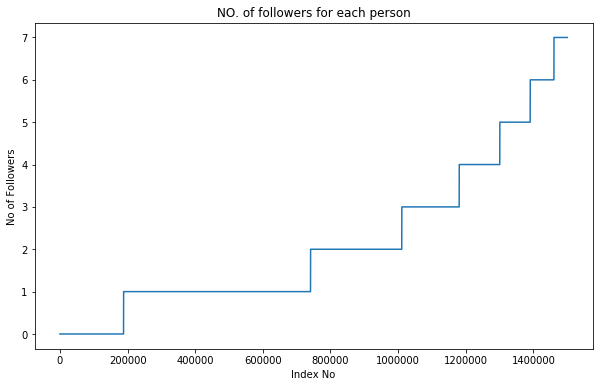

In [0]:
indegree_dist=list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.title("NO. of followers for each person")
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

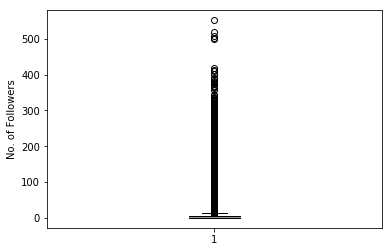

In [0]:
# Looking into boxplot
plt.boxplot(indegree_dist)
plt.ylabel("No. of Followers")
plt.show()

In [0]:
#90-100 percentile
for i in range(0,11):
  print(90+i,"percentile value is:",np.percentile(indegree_dist,90+i))

90 percentile value is: 12.0
91 percentile value is: 13.0
92 percentile value is: 14.0
93 percentile value is: 15.0
94 percentile value is: 17.0
95 percentile value is: 19.0
96 percentile value is: 21.0
97 percentile value is: 24.0
98 percentile value is: 29.0
99 percentile value is: 40.0
100 percentile value is: 552.0


#### observation:

99% of people having 40 or fewer followers

In [0]:
# Zoomed into 99-100 percentile
for i in range(10,110,10):
  print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


#### observation:
* there are 99.9% people have less than 112 followers
* only 0.1% people have more than 112 followers.

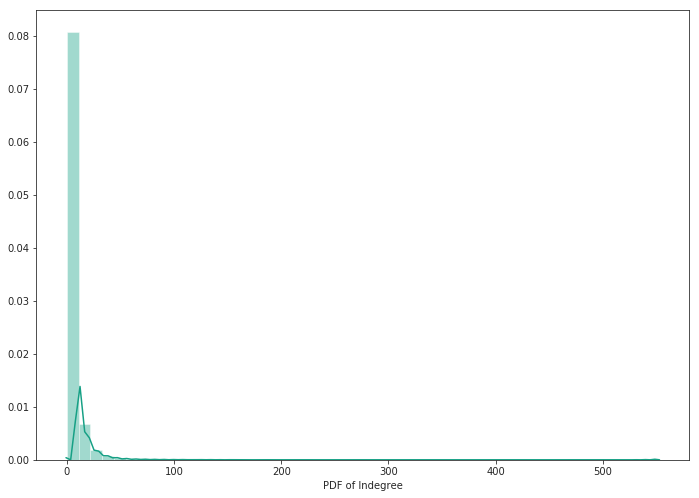

In [0]:
%matplotlib inline
sns.set_style('ticks')
fig,ax=plt.subplots()
fig.set_size_inches(11.7,8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
plt.show()

### 2.2 No of people each person is following

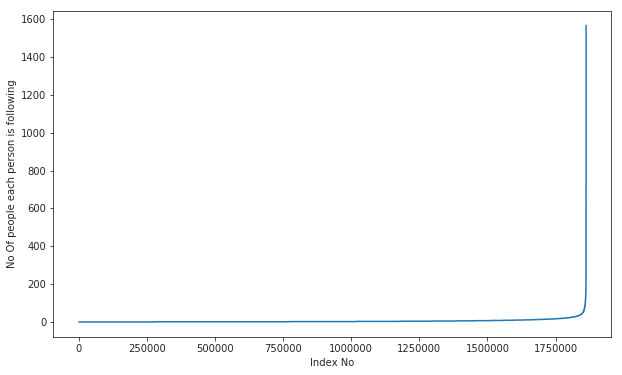

In [0]:
outdegree_dist=list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

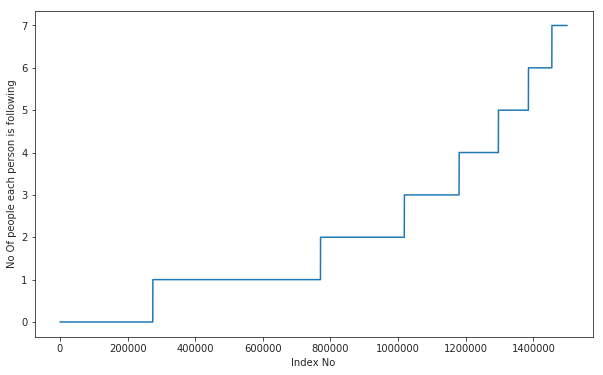

In [0]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

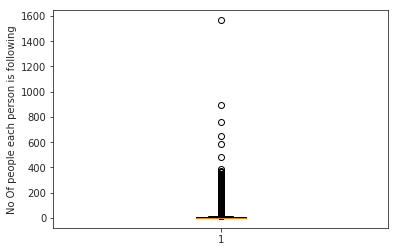

In [0]:
plt.boxplot(outdegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()


In [0]:
## 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))


90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [0]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))


99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


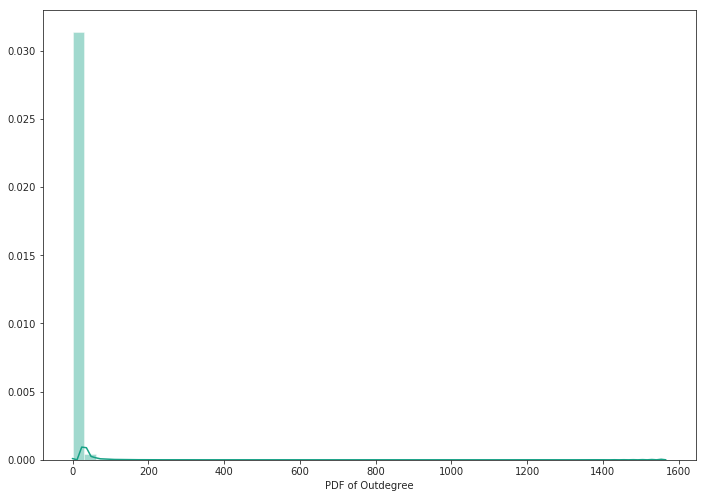

In [0]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
plt.show()

In [0]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )


No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [0]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )


No of persons having zero followers are 188043 and % is 10.097786512871734


In [0]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


### 2.3 both followers + following


In [0]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

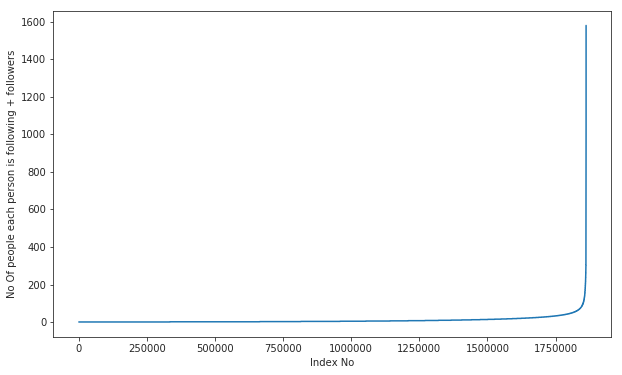

In [0]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

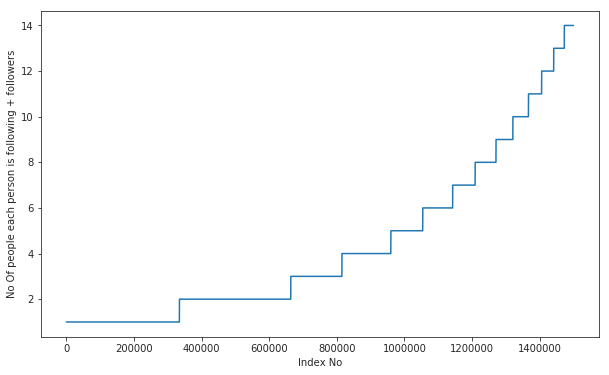

In [0]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [0]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [0]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))


99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [0]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [0]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [0]:
print('No of persons having followers + following less than 50 are',np.sum(in_out_degree<50))


No of persons having followers + following less than 50 are 1810142


In [0]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components with 2 nodes',count)

No of weakly connected components 45558
weakly connected components with 2 nodes 32195


## 3. Looking like a problem as classification problem


### 3.1 Generating some edges which are not present in graph for supervised learning

Generated Bad links from graph which are not in graph and whose shortest path is greater than 2.



In [0]:
%%time
#Generating bad edges from graph
import random
if not os.path.isfile('missing_edges_final.p'):
   #getting all set of edges
    r = csv.reader(open('train_woheader.csv','r'))
    edges=dict()
    for edge in r:
      edges[(edge[0], edge[1])] = 1
    missing_edges=set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('missing_edges_final.p','rb'))

      
      

CPU times: user 3h 50min 23s, sys: 14.6 s, total: 3h 50min 38s
Wall time: 3h 50min 43s


In [0]:
missing_edges = pickle.load(open('missing_edges_final.p','rb'))
len(missing_edges)

9437519

### 3.2 Train and Test data split

In [0]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('train_pos_after_eda.csv')) and (not os.path.isfile('test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('/content/drive/My Drive/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    print('*'*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('*'*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])
    #removing header and saving
    X_train_pos.to_csv('train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    print('deleting ........')
    del missing_edges
    



Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
************************************************************
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
************************************************************
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [0]:
if (os.path.isfile('train_pos_after_eda.csv')) and (os.path.isfile('test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print("Info about train_graph")
    print(nx.info(train_graph))
    print("\nInfo about test_graph")
    print(nx.info(test_graph))
    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())
    trY_teY=len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN=len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)
    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

        



    

Info about train_graph
Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399

Info about test_graph
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


We have here partial cold start problem here,bcz we have some nodes in only test for which we have not any info in train data.

In [118]:
#final train and test data sets
if (not os.path.isfile('train_after_eda.csv')) and \
(not os.path.isfile('test_after_eda.csv')) and \
(not os.path.isfile('train_y.csv')) and \
(not os.path.isfile('test_y.csv')) and \
(os.path.isfile('train_pos_after_eda.csv')) and \
(os.path.isfile('test_pos_after_eda.csv')) and \
(os.path.isfile('train_neg_after_eda.csv')) and \
(os.path.isfile('test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('-'*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('-'*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg))
    
    X_train.to_csv('train_after_eda.csv',header=False,index=False)
    X_test.to_csv('test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)


------------------------------------------------------------
Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
------------------------------------------------------------
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [0]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


In [0]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle

from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

# 4. Reading Data


In [0]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# 5.Similarity measures

### 5.1 Jaccard Distance:

In [0]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim


In [0]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [0]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [0]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [0]:
print(jaccard_for_followers(273084,470294))


0.0


In [0]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


### 5.2 Cosine distance:

In [0]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [0]:
print(cosine_for_followees(273084,1505602))


0.0


In [0]:
print(cosine_for_followees(273084,1635354))


0


In [0]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0


In [0]:
print(cosine_for_followers(2,470294))


0.02886751345948129


In [0]:
print(cosine_for_followers(669354,1635354))


0


### 6. Ranking Measures


### Page Ranking:

In [0]:
if not os.path.isfile('page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('page_rank.p','wb'))
else:
    pr = pickle.load(open('page_rank.p','rb'))

In [0]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))


min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [0]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)


5.615699699389075e-07


## 7.Other Graph Features


### 7.1 Shortest path:

Finding Shortest path between two nodes, if nodes have direct path i.e trivially connected then we are removing that edge and calculating path.



In [0]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [0]:
#testing
compute_shortest_path_length(10, 21)

-1

In [0]:
# testing
compute_shortest_path_length(935,3535)

10

#### 7.2 Checking for same community


In [0]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [0]:
belongs_to_same_wcc(861, 1659750)


0

In [0]:
belongs_to_same_wcc(9354,16354)


1

### 7.2 Adamic/Adar Index:


Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [0]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [0]:
calc_adar_in(1,189226)


0

In [0]:
calc_adar_in(755,534)


0

### 7.4 Is persion was following back:


In [0]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [0]:
follows_back(1,9226)


0

In [0]:
follows_back(5318,6189)


0

### 7.5 Katz Centrality:


Katz centrality computes the centrality for a node based on the centrality of its neighbors. It is a generalization of the eigenvector centrality. The Katz centrality for node i is

$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where A is the adjacency matrix of the graph G with eigenvalues$$\lambda$$.

The parameter$$\beta$$controls the initial centrality and
$$\alpha &lt; \frac{1}{\lambda_{max}}.$$
Link:
* https://en.wikipedia.org/wiki/Katz_centrality
* https://www.geeksforgeeks.org/katz-centrality-centrality-measure/

In [0]:
if not os.path.isfile('katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('katz.p','wb'))
else:
    katz = pickle.load(open('katz.p','rb'))

In [0]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [0]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


### 7.6 Hits Score

The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

* https://en.wikipedia.org/wiki/HITS_algorithm

In [0]:
if not os.path.isfile('hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('hits.p','wb'))
else:
    hits = pickle.load(open('hits.p','rb'))

In [0]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


## 8.Featurization


In [0]:
import random
if os.path.isfile('train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [0]:
if os.path.isfile('train_after_eda.csv'):
    filename = "test_after_eda.csv"
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [0]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [119]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(5)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,733917,335868,1
2,1859230,521884,1
3,375416,1027434,1
4,1253646,1002607,1


In [120]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,806059,1228951,1


### 8.1 Adding a set of features


We will create each of these feature for both train and test data points.


1.   jaccard_followers
2.   jaccard_followees
3.   cosine_followers
4.   cosine_followees
5.   num_followers_s
6.   num_followees_s
7.   num_followers_d
8.   num_followees_d
9.   inter_followers
10.  inter_followees
  



In [0]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping cosine followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping cosine followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [0]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [0]:
if not os.path.isfile('storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage1.h5', 'test_df',mode='r')

### 8.2 Adding new set of features


we will create these features for both train and test data points

1. adar index
2. is following back
3. belongs to same weakly connect components
4. shortest path between source and destination

In [0]:
if not os.path.isfile('storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)
    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    #mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
     #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage2.h5', 'test_df',mode='r')
    

### 8.3 Adding new set of features


we will create each of these features for both train and test data points

1.Weight Features
* weight of incoming edges
* weight of outgoing edges
* weight of incoming edges + weight of outgoing edges
* weight of incoming edges * weight of outgoing edges
* 2*weight of incoming edges + weight of outgoing edges
* weight of incoming edges + 2*weight of outgoing edges
2. Page Ranking of source
3. Page Ranking of dest
4. katz of source
5. katz of dest
6. hubs of source
7. hubs of dest
8. authorities_s of source
9. authorities_s of dest

### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 


$$
W = \frac{1}{\sqrt{1+|X|}}
$$

it is directed graph so calculated Weighted in and Weighted out differently.

#### credit - 
Graph-based Features for Supervised Link Prediction William Cukierski, Benjamin Hamner, Bo Yang




In [125]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:18<00:00, 98355.58it/s] 


In [0]:
if not os.path.isfile('storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [0]:
if not os.path.isfile('storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage3.h5', 'test_df',mode='r')

In [128]:
df_final_train.head()


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15
1,733917,335868,1,0.153846,0.117647,0.126491,0.213201,10,5,11,8,2,2,1.962090,1,1,2,0.408248,0.288675,0.696923,0.117851,1.105172,0.985599,2.231931e-06,9.295068e-07,0.000769,0.000751,5.670396e-12,7.010700e-13,4.459807e-14,7.911863e-14
2,1859230,521884,1,0.000000,0.000000,0.000000,0.000000,1,1,2,0,0,0,0.000000,0,0,-1,1.000000,0.707107,1.707107,0.707107,2.707107,2.414214,2.132984e-07,4.042322e-07,0.000735,0.000735,4.588894e-18,0.000000e+00,1.297211e-17,3.227019e-20
3,375416,1027434,1,0.000000,0.000000,0.000000,0.000000,3,1,2,3,0,0,0.000000,1,1,-1,1.000000,0.707107,1.707107,0.707107,2.707107,2.414214,1.040678e-06,4.042322e-07,0.000742,0.000735,4.430633e-20,3.997225e-20,2.969502e-22,3.115727e-22
4,1253646,1002607,1,0.184615,0.093023,0.038404,0.198953,87,67,107,34,24,12,5.920955,0,1,2,0.121268,0.096225,0.217493,0.011669,0.338761,0.313718,5.858111e-07,7.188382e-07,0.001274,0.001140,1.853841e-08,3.956749e-09,2.386840e-08,1.061316e-08


### Adding new feature Preferential Attachement

One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has.



#### Preferential Attachement for followers


In [129]:
#for train dataset
nfs=np.array(df_final_train['num_followers_s'])
nfd=np.array(df_final_train['num_followers_d'])
preferential_followers=[]
for i in range(len(nfs)):
    preferential_followers.append(nfd[i]*nfs[i])
df_final_train['prefer_Attach_followers']= preferential_followers
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,66
1,733917,335868,1,0.153846,0.117647,0.126491,0.213201,10,5,11,8,2,2,1.962090,1,1,2,0.408248,0.288675,0.696923,0.117851,1.105172,0.985599,2.231931e-06,9.295068e-07,0.000769,0.000751,5.670396e-12,7.010700e-13,4.459807e-14,7.911863e-14,50
2,1859230,521884,1,0.000000,0.000000,0.000000,0.000000,1,1,2,0,0,0,0.000000,0,0,-1,1.000000,0.707107,1.707107,0.707107,2.707107,2.414214,2.132984e-07,4.042322e-07,0.000735,0.000735,4.588894e-18,0.000000e+00,1.297211e-17,3.227019e-20,1
3,375416,1027434,1,0.000000,0.000000,0.000000,0.000000,3,1,2,3,0,0,0.000000,1,1,-1,1.000000,0.707107,1.707107,0.707107,2.707107,2.414214,1.040678e-06,4.042322e-07,0.000742,0.000735,4.430633e-20,3.997225e-20,2.969502e-22,3.115727e-22,3
4,1253646,1002607,1,0.184615,0.093023,0.038404,0.198953,87,67,107,34,24,12,5.920955,0,1,2,0.121268,0.096225,0.217493,0.011669,0.338761,0.313718,5.858111e-07,7.188382e-07,0.001274,0.001140,1.853841e-08,3.956749e-09,2.386840e-08,1.061316e-08,5829


In [130]:
#for test dataset
nfs=np.array(df_final_test['num_followers_s'])
nfd=np.array(df_final_test['num_followers_d'])
preferential_followers=[]
for i in range(len(nfs)):
    preferential_followers.append(nfd[i]*nfs[i])
df_final_test['prefer_Attach_followers']= preferential_followers
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers
0,848424,784690,1,0.052632,0.000000,0.029161,0.000000,6,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,1.559547e-06,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,84
1,806059,1228951,1,0.000000,0.000000,0.000000,0.000000,13,2,13,2,0,0,0.000000,1,1,2,0.577350,0.267261,0.844612,0.154303,1.421962,1.111873,7.990450e-07,2.782689e-07,0.000784,0.000739,1.089411e-16,1.202237e-17,1.590723e-15,1.357086e-18,26
2,1423723,1308306,1,0.000000,0.000000,0.000000,0.000000,3,19,0,28,0,0,0.000000,1,1,-1,0.223607,1.000000,1.223607,0.223607,1.447214,2.223607,4.493584e-07,2.693449e-06,0.000743,0.000804,0.000000e+00,3.179936e-15,2.576570e-17,3.494481e-15,57
3,261544,1200468,1,0.125000,0.090909,0.111803,0.169031,5,4,5,7,1,1,2.095903,1,1,2,0.447214,0.408248,0.855462,0.182574,1.302675,1.263710,7.942620e-07,8.395789e-07,0.000750,0.000747,9.295912e-18,3.497003e-17,1.176669e-18,1.542565e-17,20
4,1744051,976212,1,0.058824,0.083333,0.055470,0.182574,13,5,10,3,1,1,1.000000,0,1,2,0.408248,0.301511,0.709760,0.123091,1.118008,1.011271,7.819355e-07,7.859932e-07,0.000782,0.000751,3.769695e-14,7.242476e-15,2.463415e-15,1.004728e-12,65


### Preferential Attachement for followees


In [131]:
#for train dataset
nfs=np.array(df_final_train['num_followees_s'])
nfd=np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(nfs)):
    preferential_followees.append(nfd[i]*nfs[i])
df_final_train['prefer_Attach_followees']= preferential_followees
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers,prefer_Attach_followees
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,66,120
1,733917,335868,1,0.153846,0.117647,0.126491,0.213201,10,5,11,8,2,2,1.962090,1,1,2,0.408248,0.288675,0.696923,0.117851,1.105172,0.985599,2.231931e-06,9.295068e-07,0.000769,0.000751,5.670396e-12,7.010700e-13,4.459807e-14,7.911863e-14,50,88
2,1859230,521884,1,0.000000,0.000000,0.000000,0.000000,1,1,2,0,0,0,0.000000,0,0,-1,1.000000,0.707107,1.707107,0.707107,2.707107,2.414214,2.132984e-07,4.042322e-07,0.000735,0.000735,4.588894e-18,0.000000e+00,1.297211e-17,3.227019e-20,1,0
3,375416,1027434,1,0.000000,0.000000,0.000000,0.000000,3,1,2,3,0,0,0.000000,1,1,-1,1.000000,0.707107,1.707107,0.707107,2.707107,2.414214,1.040678e-06,4.042322e-07,0.000742,0.000735,4.430633e-20,3.997225e-20,2.969502e-22,3.115727e-22,3,6
4,1253646,1002607,1,0.184615,0.093023,0.038404,0.198953,87,67,107,34,24,12,5.920955,0,1,2,0.121268,0.096225,0.217493,0.011669,0.338761,0.313718,5.858111e-07,7.188382e-07,0.001274,0.001140,1.853841e-08,3.956749e-09,2.386840e-08,1.061316e-08,5829,3638


In [132]:
#for test dataset
nfs=np.array(df_final_test['num_followees_s'])
nfd=np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(nfs)):
    preferential_followees.append(nfd[i]*nfs[i])
df_final_test['prefer_Attach_followees']= preferential_followees
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers,prefer_Attach_followees
0,848424,784690,1,0.052632,0.000000,0.029161,0.000000,6,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,1.559547e-06,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,84,54
1,806059,1228951,1,0.000000,0.000000,0.000000,0.000000,13,2,13,2,0,0,0.000000,1,1,2,0.577350,0.267261,0.844612,0.154303,1.421962,1.111873,7.990450e-07,2.782689e-07,0.000784,0.000739,1.089411e-16,1.202237e-17,1.590723e-15,1.357086e-18,26,26
2,1423723,1308306,1,0.000000,0.000000,0.000000,0.000000,3,19,0,28,0,0,0.000000,1,1,-1,0.223607,1.000000,1.223607,0.223607,1.447214,2.223607,4.493584e-07,2.693449e-06,0.000743,0.000804,0.000000e+00,3.179936e-15,2.576570e-17,3.494481e-15,57,0
3,261544,1200468,1,0.125000,0.090909,0.111803,0.169031,5,4,5,7,1,1,2.095903,1,1,2,0.447214,0.408248,0.855462,0.182574,1.302675,1.263710,7.942620e-07,8.395789e-07,0.000750,0.000747,9.295912e-18,3.497003e-17,1.176669e-18,1.542565e-17,20,35
4,1744051,976212,1,0.058824,0.083333,0.055470,0.182574,13,5,10,3,1,1,1.000000,0,1,2,0.408248,0.301511,0.709760,0.123091,1.118008,1.011271,7.819355e-07,7.859932e-07,0.000782,0.000751,3.769695e-14,7.242476e-15,2.463415e-15,1.004728e-12,65,30


### 8.4 Adding new set of features


we will create each of these features for both train and test data points.



1.SVD features for both source and destination


In [0]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [0]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [0]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()


In [136]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [0]:
if not os.path.isfile('storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
  

In [139]:
df_final_train.head()


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers,prefer_Attach_followees,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,66,120,-1.666316e-13,4.613790e-13,1.043042e-05,6.678038e-13,2.451060e-13,3.584945e-12,-2.038018e-11,5.397896e-13,1.068942e-06,1.192464e-12,2.279352e-12,3.581201e-12,-7.216139e-13,3.926087e-13,1.983699e-06,1.545086e-13,8.108347e-13,1.719704e-14,-1.355367e-12,4.675237e-13,1.128566e-06,6.616573e-14,9.770932e-13,4.160011e-14
1,733917,335868,1,0.153846,0.117647,0.126491,0.213201,10,5,11,8,2,2,1.962090,1,1,2,0.408248,0.288675,0.696923,0.117851,1.105172,0.985599,2.231931e-06,9.295068e-07,0.000769,0.000751,5.670396e-12,7.010700e-13,4.459807e-14,7.911863e-14,50,88,-1.834490e-13,2.843254e-12,6.263547e-12,4.731335e-08,4.298268e-10,1.046149e-10,-8.510992e-14,2.460412e-12,2.099354e-12,1.196268e-11,4.136587e-10,1.293426e-11,-4.017736e-13,7.713187e-13,1.130689e-11,2.546553e-11,3.385454e-11,8.312668e-13,-3.979823e-13,5.676858e-13,6.589288e-12,4.751983e-10,3.378793e-11,1.474698e-12
2,1859230,521884,1,0.000000,0.000000,0.000000,0.000000,1,1,2,0,0,0,0.000000,0,0,-1,1.000000,0.707107,1.707107,0.707107,2.707107,2.414214,2.132984e-07,4.042322e-07,0.000735,0.000735,4.588894e-18,0.000000e+00,1.297211e-17,3.227019e-20,1,0,-6.962519e-15,1.263815e-11,4.360562e-15,2.094822e-14,5.526132e-14,8.472570e-17,-3.650033e-20,2.245871e-20,-1.392974e-20,-1.623020e-20,-5.677406e-20,-4.290714e-20,-8.106387e-16,1.637132e-13,5.543076e-15,1.640382e-15,4.353429e-14,2.417879e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,375416,1027434,1,0.000000,0.000000,0.000000,0.000000,3,1,2,3,0,0,0.000000,1,1,-1,1.000000,0.707107,1.707107,0.707107,2.707107,2.414214,1.040678e-06,4.042322e-07,0.000742,0.000735,4.430633e-20,3.997225e-20,2.969502e-22,3.115727e-22,3,6,-2.148874e-15,6.102341e-16,6.284133e-14,5.596405e-17,2.672529e-15,8.339277e-19,-3.438519e-17,4.910411e-15,8.935523e-15,6.817592e-16,4.834484e-16,8.750789e-19,-5.313989e-19,4.937630e-17,1.164321e-16,7.008856e-18,1.048884e-17,6.864257e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,1253646,1002607,1,0.184615,0.093023,0.038404,0.198953,87,67,107,34,24,12,5.920955,0,1,2,0.121268,0.096225,0.217493,0.011669,0.338761,0.313718,5.858111e-07,7.188382e-07,0.001274,0.001140,1.853841e-08,3.956749e-09,2.386840e-08,1.061316e-08,5829,3638,-2.054405e-12,6.159560e-11,1.913589e-11,7.156827e-10,9.903287e-10,3.420209e-07,-6.064601e-13,1.306995e-11,5.888903e-12,1.691190e-10,2.644101e-10,7.299929e-08,-1.816438e-12,5.149854e-11,1.593668e-11,6.845690e-10,6.251164e-10,4.448848e-07,-1.446844e-12,3.124515e-11,1.672530e-11,3.420197e-10,9.687014e-10,1.978195e-07


In [140]:
df_final_train.columns


Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'prefer_Attach_followers', 'prefer_Attach_followees', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

### Adding feature svd_dot


svd_dot is Dot product between sourse node svd and destination node svd features



In [0]:
#for train datasets
s1,s2,s3,s4,s5,s6=df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],df_final_train['svd_u_s_4'],df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],df_final_train['svd_v_s_4'],df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']

In [0]:
svd_dot=[]
for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))
df_final_train['svd_dot']=svd_dot

In [143]:
df_final_train.head()


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers,prefer_Attach_followees,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,66,120,-1.666316e-13,4.613790e-13,1.043042e-05,6.678038e-13,2.451060e-13,3.584945e-12,-2.038018e-11,5.397896e-13,1.068942e-06,1.192464e-12,2.279352e-12,3.581201e-12,-7.216139e-13,3.926087e-13,1.983699e-06,1.545086e-13,8.108347e-13,1.719704e-14,-1.355367e-12,4.675237e-13,1.128566e-06,6.616573e-14,9.770932e-13,4.160011e-14,1.338825e-11
1,733917,335868,1,0.153846,0.117647,0.126491,0.213201,10,5,11,8,2,2,1.962090,1,1,2,0.408248,0.288675,0.696923,0.117851,1.105172,0.985599,2.231931e-06,9.295068e-07,0.000769,0.000751,5.670396e-12,7.010700e-13,4.459807e-14,7.911863e-14,50,88,-1.834490e-13,2.843254e-12,6.263547e-12,4.731335e-08,4.298268e-10,1.046149e-10,-8.510992e-14,2.460412e-12,2.099354e-12,1.196268e-11,4.136587e-10,1.293426e-11,-4.017736e-13,7.713187e-13,1.130689e-11,2.546553e-11,3.385454e-11,8.312668e-13,-3.979823e-13,5.676858e-13,6.589288e-12,4.751983e-10,3.378793e-11,1.474698e-12,7.584908e-19
2,1859230,521884,1,0.000000,0.000000,0.000000,0.000000,1,1,2,0,0,0,0.000000,0,0,-1,1.000000,0.707107,1.707107,0.707107,2.707107,2.414214,2.132984e-07,4.042322e-07,0.000735,0.000735,4.588894e-18,0.000000e+00,1.297211e-17,3.227019e-20,1,0,-6.962519e-15,1.263815e-11,4.360562e-15,2.094822e-14,5.526132e-14,8.472570e-17,-3.650033e-20,2.245871e-20,-1.392974e-20,-1.623020e-20,-5.677406e-20,-4.290714e-20,-8.106387e-16,1.637132e-13,5.543076e-15,1.640382e-15,4.353429e-14,2.417879e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.805489e-31
3,375416,1027434,1,0.000000,0.000000,0.000000,0.000000,3,1,2,3,0,0,0.000000,1,1,-1,1.000000,0.707107,1.707107,0.707107,2.707107,2.414214,1.040678e-06,4.042322e-07,0.000742,0.000735,4.430633e-20,3.997225e-20,2.969502e-22,3.115727e-22,3,6,-2.148874e-15,6.102341e-16,6.284133e-14,5.596405e-17,2.672529e-15,8.339277e-19,-3.438519e-17,4.910411e-15,8.935523e-15,6.817592e-16,4.834484e-16,8.750789e-19,-5.313989e-19,4.937630e-17,1.164321e-16,7.008856e-18,1.048884e-17,6.864257e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.659207e-28
4,1253646,1002607,1,0.184615,0.093023,0.038404,0.198953,87,67,107,34,24,12,5.920955,0,1,2,0.121268,0.096225,0.217493,0.011669,0.338761,0.313718,5.858111e-07,7.188382e-07,0.001274,0.001140,1.853841e-08,3.956749e-09,2.386840e-08,1.061316e-08,5829,3638,-2.054405e-12,6.159560e-11,1.913589e-11,7.156827e-10,9.903287e-10,3.420209e-07,-6.064601e-13,1.306995e-11,5.888903e-12,1.691190e-10,2.644101e-10,7.299929e-08,-1.816438e-12,5.149854e-11,1.593668e-11,6.845690e-10,6.251164e-10,4.448848e-07,-1.446844e-12,3.124515e-11,1.672530e-11,3.420197e-10,9.687014e-10,1.978195e-07,1.129754e-13


In [0]:
#for test dataset
s1,s2,s3,s4,s5,s6=df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']


In [0]:
svd_dot=[]
for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))
df_final_test['svd_dot']=svd_dot

In [146]:
df_final_test.head()


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers,prefer_Attach_followees,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,848424,784690,1,0.052632,0.000000,0.029161,0.000000,6,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,1.559547e-06,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,84,54,-9.987979e-12,2.283697e-13,1.439962e-10,6.136186e-13,4.188165e-13,5.983250e-15,-1.026186e-11,5.316533e-13,5.843195e-10,1.166050e-13,2.253338e-11,3.220340e-15,-2.148852e-13,1.883257e-13,5.904779e-11,2.701541e-12,4.341579e-13,5.535503e-14,-9.994077e-10,5.791914e-10,3.512355e-07,2.486666e-09,2.771140e-09,1.727695e-12,2.083218e-17
1,806059,1228951,1,0.000000,0.000000,0.000000,0.000000,13,2,13,2,0,0,0.000000,1,1,2,0.577350,0.267261,0.844612,0.154303,1.421962,1.111873,7.990450e-07,2.782689e-07,0.000784,0.000739,1.089411e-16,1.202237e-17,1.590723e-15,1.357086e-18,26,26,-1.263765e-13,5.158732e-10,6.218300e-12,3.536173e-13,4.546838e-12,2.009917e-15,-8.781041e-12,2.729455e-11,5.771186e-13,2.447607e-14,4.677208e-14,2.219017e-16,-7.201285e-13,1.712971e-10,2.477619e-11,1.115192e-12,4.365123e-12,2.964961e-14,-9.150470e-14,4.498091e-12,1.206770e-12,7.088207e-14,2.933581e-14,2.529833e-17,1.488613e-20
2,1423723,1308306,1,0.000000,0.000000,0.000000,0.000000,3,19,0,28,0,0,0.000000,1,1,-1,0.223607,1.000000,1.223607,0.223607,1.447214,2.223607,4.493584e-07,2.693449e-06,0.000743,0.000804,0.000000e+00,3.179936e-15,2.576570e-17,3.494481e-15,57,0,7.278583e-20,-7.534829e-20,5.110667e-20,3.419329e-20,1.641347e-19,1.157607e-19,-1.929175e-12,1.326148e-12,3.795025e-06,6.188523e-13,1.909949e-11,5.866909e-14,-2.041366e-14,1.323809e-14,8.742555e-08,6.453141e-15,1.535693e-13,4.802589e-16,-4.643264e-13,1.103043e-12,3.482290e-07,1.511915e-12,4.643837e-13,6.513389e-14,3.044411e-14
3,261544,1200468,1,0.125000,0.090909,0.111803,0.169031,5,4,5,7,1,1,2.095903,1,1,2,0.447214,0.408248,0.855462,0.182574,1.302675,1.263710,7.942620e-07,8.395789e-07,0.000750,0.000747,9.295912e-18,3.497003e-17,1.176669e-18,1.542565e-17,20,35,-7.876539e-15,5.211446e-12,1.783380e-14,1.195467e-15,5.298158e-14,1.715107e-16,-7.731091e-14,5.238784e-08,1.843872e-11,7.685399e-14,2.272694e-12,6.449869e-16,-2.659669e-13,7.530837e-10,3.174184e-12,3.957520e-15,1.854378e-13,2.192907e-17,-3.905456e-15,1.866349e-12,7.599484e-12,8.935259e-15,2.063146e-13,2.875134e-16,2.744465e-19
4,1744051,976212,1,0.058824,0.083333,0.055470,0.182574,13,5,10,3,1,1,1.000000,0,1,2,0.408248,0.301511,0.709760,0.123091,1.118008,1.011271,7.819355e-07,7.859932e-07,0.000782,0.000751,3.769695e-14,7.242476e-15,2.463415e-15,1.004728e-12,65,30,-3.093239e-11,1.962855e-11,5.168332e-11,2.166217e-12,1.840756e-11,6.954754e-13,-4.347309e-14,4.588334e-14,2.888791e-12,2.551255e-13,6.463718e-14,1.336183e-13,-5.103108e-13,4.301406e-13,1.745179e-12,2.508755e-13,4.757348e-13,4.591566e-14,-2.477948e-12,2.965707e-12,3.064164e-10,2.613222e-11,7.412460e-12,1.872720e-11,7.016170e-22


In [0]:
hdf = HDFStore('storage_sample_stage4.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

## 9.Machine Learning models

### 9.1 Import libraries:

In [0]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

### 9.2 Exploring about data

In [148]:
df_final_train.columns


Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'prefer_Attach_followers', 'prefer_Attach_followees', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'svd_dot'],
      dtype='object')

### 9.3 Preparing the data for model training

In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [0]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

### 9.4 Random Forest with hyperparameter tuning

#### 9.4.1 hyperparameter estimater tuned by grid search

Estimators =  10 Train Score 0.911845845176392 test Score 0.9054806070826306
Estimators =  50 Train Score 0.9215458512541989 test Score 0.895571115597749
Estimators =  100 Train Score 0.924416965190237 test Score 0.9173616376042456
Estimators =  250 Train Score 0.9232877858921508 test Score 0.9168512775070151
Estimators =  450 Train Score 0.9234723731505476 test Score 0.9171056513127397


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

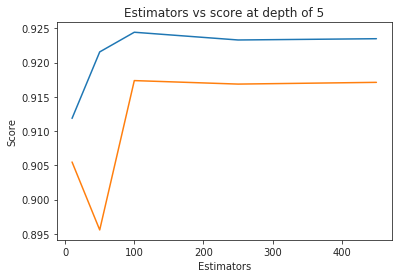

In [153]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

#### 9.4.2 hyperparameter depth tuned by grid search

depth =  3 Train Score 0.8754593972707807 test Score 0.8548801183586441
depth =  9 Train Score 0.9594397907357837 test Score 0.9192796610169491
depth =  11 Train Score 0.962225267752906 test Score 0.9228982814677194
depth =  15 Train Score 0.9641024600969436 test Score 0.9212090445671257
depth =  20 Train Score 0.964398998753509 test Score 0.9242315638571489
depth =  35 Train Score 0.9643768996960486 test Score 0.9242765917089927
depth =  50 Train Score 0.9643768996960486 test Score 0.9242765917089927
depth =  70 Train Score 0.9643768996960486 test Score 0.9242765917089927
depth =  130 Train Score 0.9643768996960486 test Score 0.9242765917089927


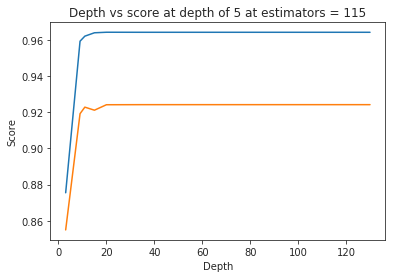

In [154]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()


#### 9.4.3 Randomized search on hyper parameters.



In [157]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,return_train_score=True,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.9632652  0.96304779 0.96168722 0.96286611 0.96456872]
mean train scores [0.96426177 0.96374052 0.96243396 0.96366543 0.96524468]


In [158]:
print(rf_random.best_estimator_)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [0]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [0]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [162]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))


Train f1 score 0.9655360994926121
Test f1 score 0.9249451846854444


#### 9.4.4 Analysis of results by confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


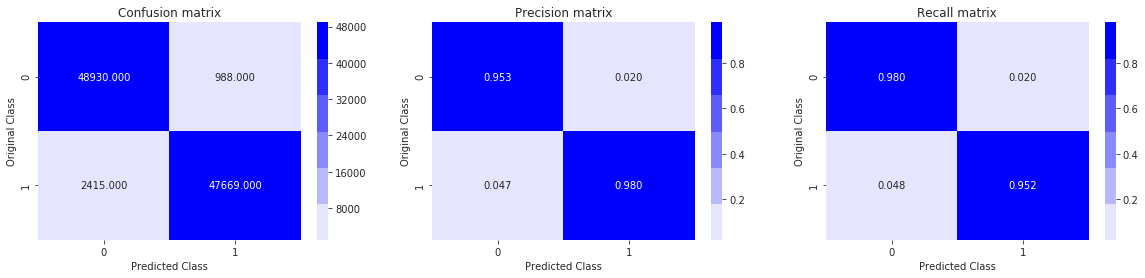

Test confusion_matrix


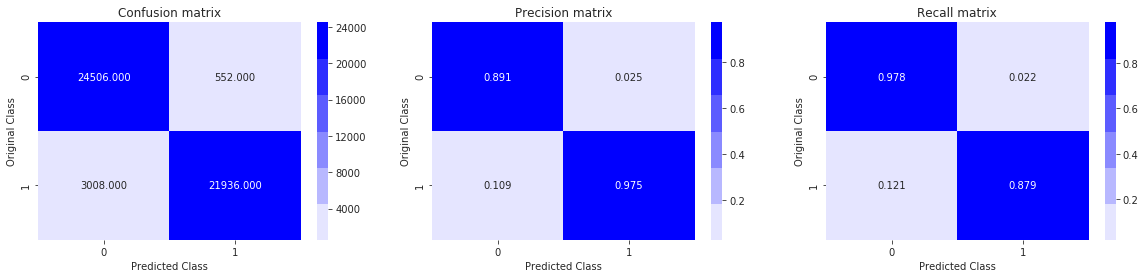

In [164]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

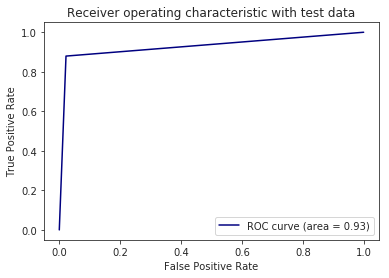

In [165]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

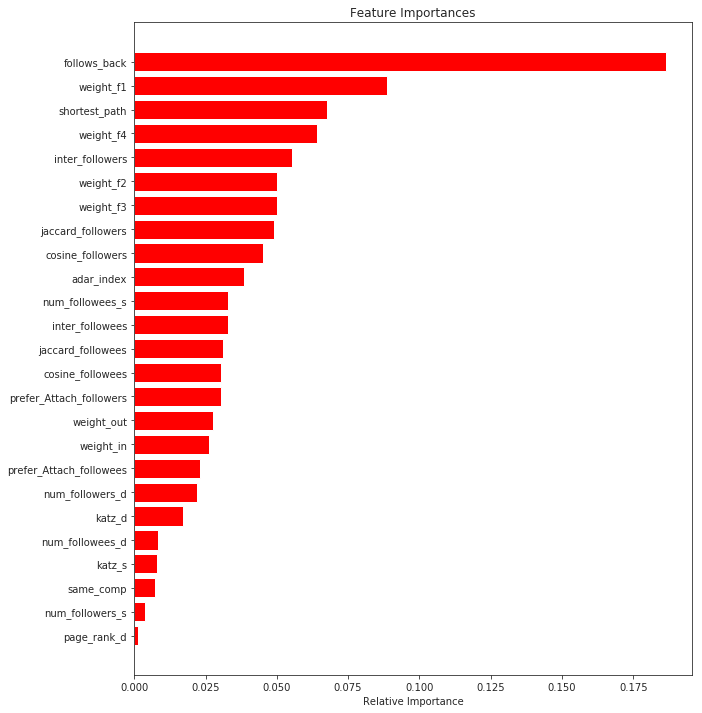

In [166]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 10.XGBOOST with hyperparameter tuning

In [168]:
import xgboost as xgb
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15)
              }
model = RandomizedSearchCV(clf, param_distributions=param_dist,return_train_score=True,
                                   n_iter=5,cv=3,scoring='f1',random_state=25)


model.fit(df_final_train,y_train)
print('mean test scores',model.cv_results_['mean_test_score'])
print('mean train scores',model.cv_results_['mean_train_score'])

mean test scores [0.98037631 0.98032744 0.98063733 0.9802465  0.98031915]
mean train scores [1.         1.         0.99379991 0.99673149 0.99699739]


In [169]:
print(model.best_estimator_)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=109, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [0]:
clf=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=109,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [0]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [172]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9920539369130749
Test f1 score 0.927862174318934


Train confusion_matrix


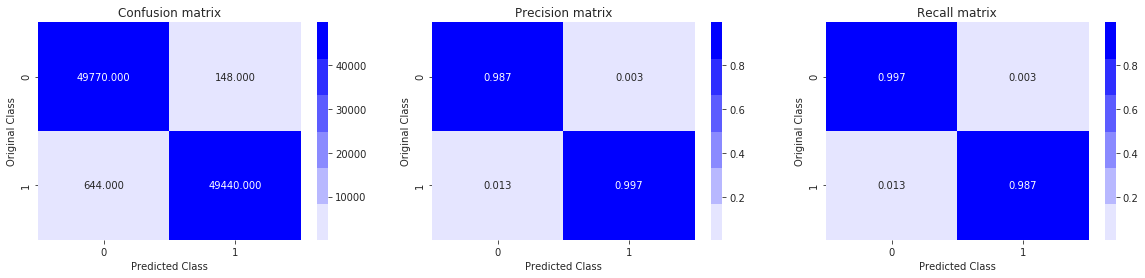

Test confusion_matrix


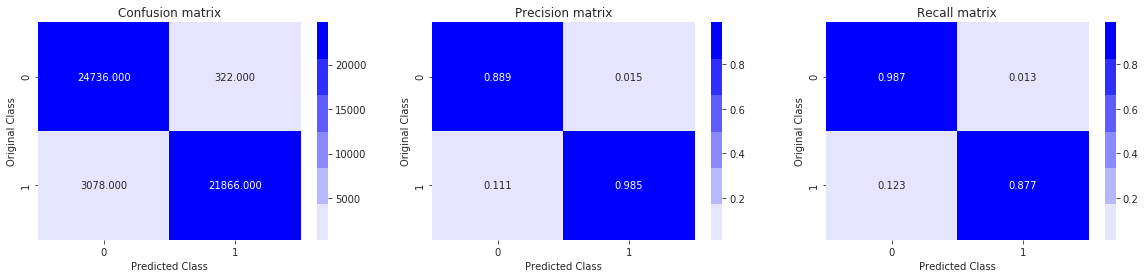

In [173]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

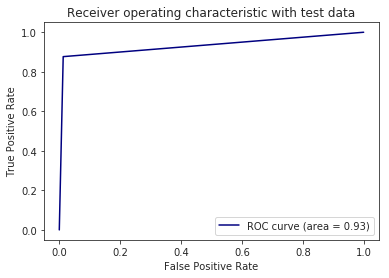

In [175]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

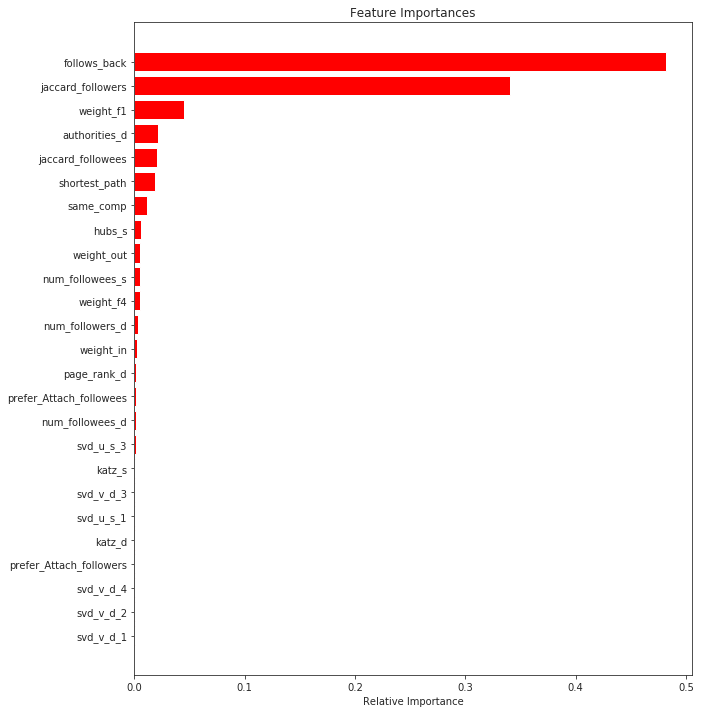

In [176]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 11.Procedure and Observation


In [174]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "n_estimators", "max_depth", "Train f1-Score","Test f1-Score"]
x.add_row(['Random Forest','121','14','0.964','0.921'])
x.add_row(['XGBOOST','109','10','0.992','0.926'])
print(x)

+---------------+--------------+-----------+----------------+---------------+
|     Model     | n_estimators | max_depth | Train f1-Score | Test f1-Score |
+---------------+--------------+-----------+----------------+---------------+
| Random Forest |     121      |     14    |     0.964      |     0.921     |
|    XGBOOST    |     109      |     10    |     0.992      |     0.926     |
+---------------+--------------+-----------+----------------+---------------+


## Observations:
1. First we have done Exploratory data analysis  such as number of followers and followees of each person.
2. we have only class 1 data set so,we add some datapoints belongs to class 0.
3. Initially we have only two features,after performing some feature engineering like finding shortest path, kartz centrality, jaccard distances, page rank, preferential attachements etc, we add about 55 features more.
4. After performing eploratory data analysis and feature engineering we splitted whole dataset into train and test(80:20) ratio and performed random forest and xgboost taking f1-score as our metric.
5. At the end of training we add table for showing results on both ML models.